### Analysis
Building a regression model to predict climbing ability from reported training strategies. 

### Imports
All imports are included here:

In [1]:
import numpy as np
import pandas as pd

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import SGDRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score

import matplotlib.pyplot as plt
import seaborn as sns
import joblib

### Data imputation
The remaining missing data seems to be missing completely at random.

I'll try two strategies and see which offers the best results:

**1. No data imputation by dropping rows/columns with `np.nan` :**
- Advantage: Avoids potential bias from imputing data. Gives a good benchmark.
- Disadvantage: Less training data, loss of power.

**2. Imputing missing values in `X_train` and `X_test`:**
- Advantage: Potentially more power as can utilise the train set more fully.
- Disadvantage: Imputation can often bias the model and make it perform worse.

In [2]:
np.random.seed(1)
df = pd.read_csv("cleaned_data.csv")

for col in list(df):
    missing = df[col].isnull().sum()
    if missing > 0:
        print("{} has {} missing values".format(col, missing))

arm_span_cm has 33 missing values
max_pull_ups has 120 missing values
climbing_session_length has 2 missing values
general_strength_session_length has 5 missing values
campus_session_length has 2 missing values
max_boulder_grade has 17 missing values


### 1. No data imputation by dropping rows/columns with `np.nan`

In [3]:
df_drop_na = df.copy()
df_drop_na = df_drop_na.drop(columns=["max_pull_ups", "arm_span_cm"]) #  Drop cols with lots of np.nans
df_drop_na = df_drop_na.dropna() #  Drop remaining rows with nas

print("Dataset has shape: {}".format(df_drop_na.shape))
print("{} np.nan values in dataset".format(df_drop_na.isna().values.sum()))

X = df_drop_na.drop(columns="max_boulder_grade")
y = df_drop_na["max_boulder_grade"]

Dataset has shape: (512, 49)
0 np.nan values in dataset


I'll train different regressors, and use 5-fold cross validation and assess the model fit with the R^2 value.

In [4]:
from sklearn.svm import SVR
reg_models = [["ranfor", RandomForestRegressor()],
              ["linreg", LinearRegression()],
              ["ridge", Ridge()],
              ["lasso", Lasso()]]

for name, model in reg_models:
    scores = cross_val_score(model, X, y, cv=5, scoring="r2")
    print("{}: R^2: {:.3f} +/- {:.3f}".format(name, scores.mean(), scores.std() * 2))

ranfor: R^2: 0.506 +/- 0.158
linreg: R^2: 0.517 +/- 0.112
ridge: R^2: 0.522 +/- 0.119
lasso: R^2: 0.311 +/- 0.101


### 2. Imputing np.nan in `X_train` and `X_test`:
Let's see if we can improve this R^2 score by imputing the missing values instead. I'll use the `IterarativeImputer()` function from scikit-learn. This will (by defualt) impute values sequentially using Bayesian ridge regression.

In [5]:
df_impute = df.copy()
df_impute = df_impute[df_impute['max_boulder_grade'].notna()] # Keep all na rows except in our dependant variable
print(df_impute.shape)

(520, 51)


In [6]:
X = df_impute.drop(columns = "max_boulder_grade")
y = df_impute["max_boulder_grade"]

for name, model in reg_models:
    pipeline = Pipeline([
        ("imputer", IterativeImputer(max_iter=100)),
        (name, model)
    ])

    scores = cross_val_score(pipeline, X, y, cv=5, scoring="r2")
    print("{}: R^2: {:.3f} +/- {:.3f}".format(name, scores.mean(), scores.std() * 2))

ranfor: R^2: 0.537 +/- 0.127
linreg: R^2: 0.542 +/- 0.074
ridge: R^2: 0.546 +/- 0.077
lasso: R^2: 0.433 +/- 0.126


Imputation is significantly better, increased the R^2 value by ~0.03.

### Hyperparameter tuning
I will drop lasso regression as it has not been performing well, and try hyperparameter tuning with the other regressors to see if we can improve the R^2 score.

In [11]:
X = df_impute.drop(columns = "max_boulder_grade")
y = df_impute["max_boulder_grade"]

ranfor_param_grid = {
    "imputer__initial_strategy": ["mean", "median"],
    "ranfor__n_estimators": [100, 500, 1000],
}

ridge_param_grid = {
    "ridge__alpha": [1, 0.1,0.01,0.001,0.0001,0]
}

reg_models = [["ranfor", RandomForestRegressor(), ranfor_param_grid],
              ["linreg", LinearRegression(), {}], # Not really any hyperparameters for linear regression.
              ["ridge", Ridge(), ridge_param_grid]
             ]

best_estimators = {}
for name, model, param_grid in reg_models:
    pipeline = Pipeline([
        ("imputer", IterativeImputer(max_iter=100)),
        (name, model)
    ])
    grid = GridSearchCV(pipeline, cv=5, param_grid=param_grid, scoring="r2")
    grid.fit(X, y)
    std = grid.cv_results_["std_test_score"][grid.cv_results_["rank_test_score"]==1][0]
    best_estimators[name] = grid.best_estimator_
    print(name)
    print("Best score: R^2 = {:.3f} +/- {:.3}".format(grid.best_score_, std*2))
    print("Achieved with hyperparameters:\n{}\n".format(grid.best_params_))

ranfor
Best score: R^2 = 0.550 +/- 0.13
Achieved with hyperparameters:
{'imputer__initial_strategy': 'median', 'ranfor__n_estimators': 1000}

linreg
Best score: R^2 = 0.542 +/- 0.0743
Achieved with hyperparameters:
{}

ridge
Best score: R^2 = 0.546 +/- 0.0775
Achieved with hyperparameters:
{'ridge__alpha': 1}



The random forest classifier seems to provide the best R^2 value after hyperparameter tuning.

### Feature importances

Feature importance in scikit-learn is assessed by how much a feature decreases the weighted variance in a tree. It is related to the depths of the decision nodes that the feature used for in the tree.

In [12]:
ranfor = best_estimators["ranfor"].named_steps["ranfor"]
importances = pd.DataFrame({"feature": list(X), "importance": ranfor.feature_importances_})
importances = importances.sort_values("importance", ascending=False)

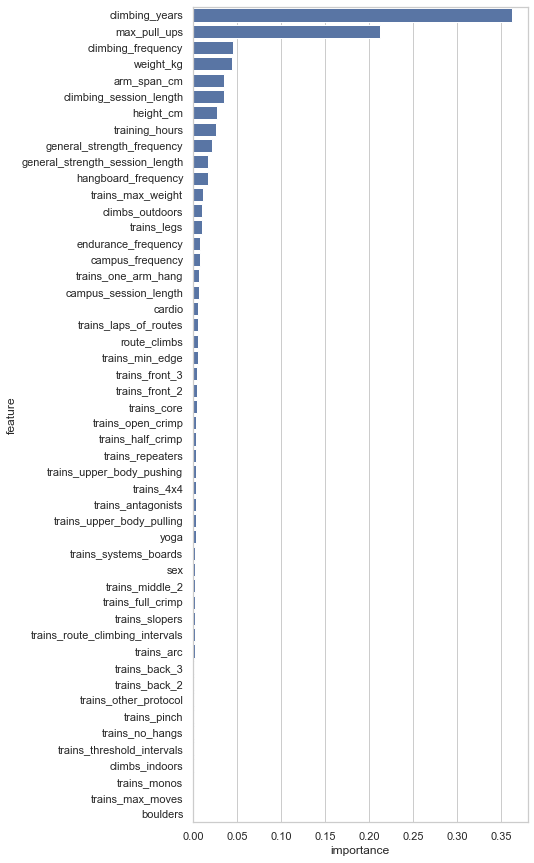

In [13]:
sns.set(style="whitegrid")
f, ax = plt.subplots(figsize=(6, 15))
sns.barplot(x="importance", y="feature", data=importances, color="b")

**Notes:**
- Climbing years seems to be by far the most important feature.
- Some of the rare categorical features have little chance of being chosen in the decision tree. For example `trains_monos` which I know should be strongly associated with climbing ability, has an importance of 0.
- `sex` has very little importance, presumable because the differences in sex is accounted for by measurements of strength (such as max_pull_ups).

### Save model

In [14]:
joblib.dump(best_estimators["ranfor"], 'ranfor_model.joblib', compress = 1) 

['ranfor_model.joblib']